# Imports

In [188]:
import mlflow
import pandas as pd
import seaborn as sns
import re
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Reading Data

In [157]:
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')

In [158]:
train_data.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy


# basic Eda

In [159]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38932 entries, 0 to 38931
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   User_ID       38932 non-null  object
 1   Description   38932 non-null  object
 2   Browser_Used  38932 non-null  object
 3   Device_Used   38932 non-null  object
 4   Is_Response   38932 non-null  object
dtypes: object(5)
memory usage: 1.5+ MB


In [56]:
train_data['Is_Response'].value_counts()/len(train_data)

happy        0.681213
not happy    0.318787
Name: Is_Response, dtype: float64

In [57]:
train_data[train_data.duplicated()]

,User_ID,Description,Browser_Used,Device_Used,Is_Response


In [58]:
train_data['Browser_Used'].value_counts()

Firefox              7367
Edge                 7134
Google Chrome        4659
InternetExplorer     4588
Mozilla Firefox      4328
Mozilla              3092
Chrome               2470
IE                   2439
Internet Explorer    2103
Safari                390
Opera                 362
Name: Browser_Used, dtype: int64

In [59]:
train_data['Device_Used'].value_counts()

Desktop    15026
Mobile     14976
Tablet      8930
Name: Device_Used, dtype: int64

In [61]:
def check_response_distribution(subset_cols):
    
    print(train_data[train_data['Browser_Used'].isin(subset_cols)]['Is_Response'].value_counts(normalize=True))
    

In [62]:
check_response_distribution(['Mozilla Firefox'])

happy        0.740065
not happy    0.259935
Name: Is_Response, dtype: float64


In [63]:
check_response_distribution(['Firefox'])

happy        0.500204
not happy    0.499796
Name: Is_Response, dtype: float64


In [64]:
check_response_distribution(['Mozilla'])

happy        0.595408
not happy    0.404592
Name: Is_Response, dtype: float64


In [65]:
check_response_distribution(['Firefox','Mozilla Firefox'])

happy        0.58897
not happy    0.41103
Name: Is_Response, dtype: float64


In [66]:
check_response_distribution(['IE','Internet Explorer'])

happy        0.86834
not happy    0.13166
Name: Is_Response, dtype: float64


In [67]:
check_response_distribution(['IE','InternetExplorer'])

happy        0.863242
not happy    0.136758
Name: Is_Response, dtype: float64


In [68]:
check_response_distribution(['IE'])

happy        0.860599
not happy    0.139401
Name: Is_Response, dtype: float64


In [69]:
train_data[train_data['Browser_Used'].isin(['Chrome'])]['Is_Response'].value_counts(normalize=True)

happy        0.851417
not happy    0.148583
Name: Is_Response, dtype: float64

In [70]:
train_data[train_data['Browser_Used'].isin(['Google Chrome'])]['Is_Response'].value_counts(normalize=True)

happy        0.866066
not happy    0.133934
Name: Is_Response, dtype: float64

In [71]:
train_data[train_data['Browser_Used'].isin(['Edge'])]['Is_Response'].value_counts(normalize=True)

not happy    0.548921
happy        0.451079
Name: Is_Response, dtype: float64

In [72]:
train_data[train_data['Browser_Used'].isin(['Opera'])]['Is_Response'].value_counts(normalize=True)

happy        0.665746
not happy    0.334254
Name: Is_Response, dtype: float64

In [73]:
train_data[train_data['Browser_Used'].isin(['Safari'])]['Is_Response'].value_counts(normalize=True)

happy        0.728205
not happy    0.271795
Name: Is_Response, dtype: float64

## Merging Similar Browser used values

In [160]:
map_dict = {'Google Chrome':'Chrome',
           'InternetExplorer':'IE',
           'Internet Explorer':'IE',
           'Mozilla Firefox':'Firefox',
           'Mozilla':'Firefox'}

In [167]:
def map_browser(df):
    
    
    df['Browser_Used'] = df['Browser_Used'].replace(map_dict)

    return df
    
    

In [163]:
train_data = map_browser(train_data)

train_data['Browser_Used'].value_counts()

Firefox    14787
IE          9130
Edge        7134
Chrome      7129
Safari       390
Opera        362
Name: Browser_Used, dtype: int64

<AxesSubplot:xlabel='Device_Used', ylabel='count'>

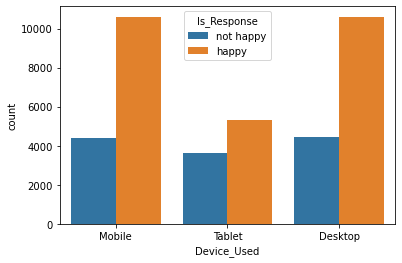

In [81]:
sns.countplot(data=train_data,x='Device_Used',hue='Is_Response')

<AxesSubplot:xlabel='Browser_Used', ylabel='count'>

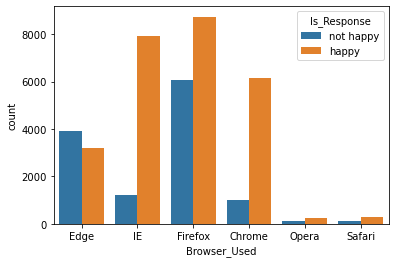

In [82]:
sns.countplot(data=train_data,x='Browser_Used',hue='Is_Response')

In [86]:
train_data['desc_len'] = train_data['Description'].str.len()
train_data['desc_len'].describe()

count    38932.000000
mean       866.276482
std        719.255343
min         20.000000
25%        405.000000
50%        676.000000
75%       1095.000000
max      14340.000000
Name: desc_len, dtype: float64

<AxesSubplot:xlabel='Is_Response', ylabel='desc_len'>

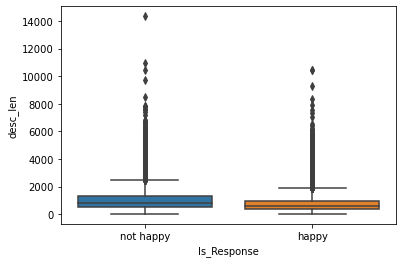

In [87]:
sns.boxplot(data=train_data,y='desc_len',x='Is_Response')

In [88]:
train_data['Description_wcount'] = train_data['Description'].apply(lambda x: len(x.split()))
train_data['Description_wcount'].describe()

count    38932.000000
mean       157.347555
std        131.056426
min          4.000000
25%         73.000000
50%        123.000000
75%        199.000000
max       2289.000000
Name: Description_wcount, dtype: float64

<AxesSubplot:xlabel='Is_Response', ylabel='Description_wcount'>

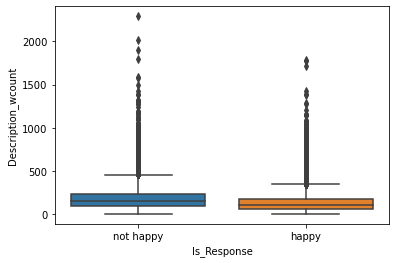

In [89]:
sns.boxplot(data=train_data,y='Description_wcount',x='Is_Response')

In [90]:
train_data[train_data['Description_wcount'] > 512].describe()

,desc_len,Description_wcount
count,893.000000,893.000000
mean,3813.262038,695.189250
std,1161.766030,206.991808
min,2515.000000,513.000000
25%,3080.000000,564.000000
50%,3455.000000,630.000000
75%,4097.000000,747.000000
max,14340.000000,2289.000000


1. \n -> with ' '
2. multiple """""""" with ''
3. numbers are replaced with $--,--, -th, -st, --nd, --rd , to be replaced with ''

## Cleaning the text

In [91]:
train_data['Description'].iloc[1]

"I stayed at the Crown Plaza April -- - April --, ----. The staff was friendly and attentive. The elevators are tiny (about -' by -'). The food in the restaurant was delicious but priced a little on the high side. Of course this is Washington DC. There is no pool and little for children to do. My room on the fifth floor had two comfortable beds and plenty of space for one person. The TV is a little small by todays standards with a limited number of channels. There was a small bit of mold in the bathtub area that could have been removed with a little bleach. It appeared the carpets were not vacummed every day. I reported a light bulb was burned out. It was never replaced. Ice machines are on the odd numbered floors, but the one on my floor did not work. I encountered some staff in the elevator one evening and I mentioned the ice machine to them. Severel hours later a maid appeared at my door with ice and two mints. I'm not sure how they knew what room I was in. That was a little unnervi

In [92]:
a = train_data['Description'].iloc[1].replace('\n', ' ')
a

"I stayed at the Crown Plaza April -- - April --, ----. The staff was friendly and attentive. The elevators are tiny (about -' by -'). The food in the restaurant was delicious but priced a little on the high side. Of course this is Washington DC. There is no pool and little for children to do. My room on the fifth floor had two comfortable beds and plenty of space for one person. The TV is a little small by todays standards with a limited number of channels. There was a small bit of mold in the bathtub area that could have been removed with a little bleach. It appeared the carpets were not vacummed every day. I reported a light bulb was burned out. It was never replaced. Ice machines are on the odd numbered floors, but the one on my floor did not work. I encountered some staff in the elevator one evening and I mentioned the ice machine to them. Severel hours later a maid appeared at my door with ice and two mints. I'm not sure how they knew what room I was in. That was a little unnervi

In [93]:
a = re.sub(r'\$*--(th|st|rd|nd)*|("")+'," ",a)
a

"I stayed at the Crown Plaza April   - April  ,   . The staff was friendly and attentive. The elevators are tiny (about -' by -'). The food in the restaurant was delicious but priced a little on the high side. Of course this is Washington DC. There is no pool and little for children to do. My room on the fifth floor had two comfortable beds and plenty of space for one person. The TV is a little small by todays standards with a limited number of channels. There was a small bit of mold in the bathtub area that could have been removed with a little bleach. It appeared the carpets were not vacummed every day. I reported a light bulb was burned out. It was never replaced. Ice machines are on the odd numbered floors, but the one on my floor did not work. I encountered some staff in the elevator one evening and I mentioned the ice machine to them. Severel hours later a maid appeared at my door with ice and two mints. I'm not sure how they knew what room I was in. That was a little unnerving! 

In [166]:
def clean_desc(df:pd.DataFrame):
    
    df['Description'] = df['Description'].str.replace('\n',"").replace(r'\$*--(th|st|rd|nd)*|("")+','',regex=True)
    
    return df


# train_data['Description'] = train_data['Description'].str.replace('\n',"").replace(r'\$*--(th|st|rd|nd)*|("")+','',regex=True)

In [95]:
train_data

,User_ID,Description,Browser_Used,Device_Used,Is_Response,desc_len,Description_wcount
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy,248,46
1,id10327,"I stayed at the Crown Plaza April - April , ....",IE,Mobile,not happy,1077,208
2,id10328,I booked this hotel through Hotwire at the low...,Firefox,Tablet,not happy,1327,232
3,id10329,Stayed here with husband and sons on the way t...,IE,Desktop,happy,502,93
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy,1613,297
...,...,...,...,...,...,...,...
38927,id49253,We arrived late at night and walked in to a ch...,Edge,Desktop,happy,769,140
38928,id49254,The only positive impression is location and p...,IE,Mobile,not happy,533,90
38929,id49255,Traveling with friends for shopping and a show...,Firefox,Mobile,not happy,1065,207
38930,id49256,The experience was just ok. We paid extra for ...,Chrome,Desktop,not happy,519,102


In [164]:
def preprocess(df):
    
    df = map_browser(df)
    df = clean_desc(df)
    
    return df

## Baseline Model

In [178]:
ct = ColumnTransformer([
    ('Tfidf_vectorizer',TfidfVectorizer(),'Description'),
    ('ohe_bu',OneHotEncoder(),['Browser_Used','Device_Used']),

])

In [179]:
pipe_lr = Pipeline([
    ('ct',ct),
    ('lr',LogisticRegression())
])

In [180]:
pipe_lr.fit(train_data,train_data['Is_Response'])

C:\Users\Sagar\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('Tfidf_vectorizer',
                                                  TfidfVectorizer(),
                                                  'Description'),
                                                 ('ohe_bu', OneHotEncoder(),
                                                  ['Browser_Used',
                                                   'Device_Used'])])),
                ('lr', LogisticRegression())])

In [181]:
pipe_lr.feature_names_in_

array(['User_ID', 'Description', 'Browser_Used', 'Device_Used',
       'Is_Response'], dtype=object)

In [182]:
test_data

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id80132,Looking for a motel in close proximity to TV t...,Firefox,Mobile,not happy
1,id80133,Walking distance to Madison Square Garden and ...,IE,Desktop,happy
2,id80134,Visited Seattle on business. Spent - nights in...,IE,Tablet,happy
3,id80135,This hotel location is excellent and the rooms...,Edge,Mobile,not happy
4,id80136,This hotel is awesome I love the service Antho...,Firefox,Mobile,happy
...,...,...,...,...,...
29399,id109531,I stayed at the hotel and towers for a confere...,Chrome,Mobile,happy
29400,id109532,Trying to stay within the Marriott family and ...,IE,Tablet,happy
29401,id109533,"We stayed for - nights with our little dog,ver...",Edge,Desktop,happy
29402,id109534,Stayed at the Yotel over the weekend and was v...,IE,Desktop,happy


In [185]:
lr_pred = test_data[['User_ID']]

In [186]:
lr_pred['Is_Response'] = pipe_lr.predict(preprocess(test_data))

C:\Users\Sagar\AppData\Local\Temp/ipykernel_40040/851525991.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lr_pred['Is_Response'] = pipe_lr.predict(preprocess(test_data))


In [187]:
lr_pred[['User_ID','Is_Response']].to_csv('lr_pred_baseline_submission.csv',index=False)

In [189]:
pipe_lr.get_params()

{'memory': None,
 'steps': [('ct',
   ColumnTransformer(transformers=[('Tfidf_vectorizer', TfidfVectorizer(),
                                    'Description'),
                                   ('ohe_bu', OneHotEncoder(),
                                    ['Browser_Used', 'Device_Used'])])),
  ('lr', LogisticRegression())],
 'verbose': False,
 'ct': ColumnTransformer(transformers=[('Tfidf_vectorizer', TfidfVectorizer(),
                                  'Description'),
                                 ('ohe_bu', OneHotEncoder(),
                                  ['Browser_Used', 'Device_Used'])]),
 'lr': LogisticRegression(),
 'ct__n_jobs': None,
 'ct__remainder': 'drop',
 'ct__sparse_threshold': 0.3,
 'ct__transformer_weights': None,
 'ct__transformers': [('Tfidf_vectorizer', TfidfVectorizer(), 'Description'),
  ('ohe_bu', OneHotEncoder(), ['Browser_Used', 'Device_Used'])],
 'ct__verbose': False,
 'ct__verbose_feature_names_out': True,
 'ct__Tfidf_vectorizer': TfidfVectorizer(),


#### Accuracy ---> 0.64036 with baseline LR model, tuning with class weights and alphas

In [ ]:
param_grid = {'lr__C':[pow(10,x) for x in (-3,4)],'lr_class_weight':[]}
gs_lr = GridSearchCV(pipe_lr,param_grid)